Sparsity constrains on neuronal activation are imposed with the following loss function 

\begin{equation}
    \mathcal{L}\left(\pmb{a}_1, \pmb{W}\right) = \frac{1}{2}|| \pmb{a}_0 - \pmb{W}^T \pmb{a}_1 ||_2^2 + \lambda S\left( \pmb{a}_1 \right)
\end{equation}

where $S(\pmb{x})$ denotes sparsity constraint typically assumed to be an L1 norm. For example, when $S(\pmb{x}) =  \sum_i C(x_i)$
and $C(x) = |x|$ we obtain the L1 norm, thus $S(\pmb{x}) = ||\pmb{x}||_1$. However, in practice the cost function $C(x)$ can have any sutiable functional form (monotonically increasing with $x$ ) more complex representation. 

The  gradient of the loss function with respect to single neuron activation $a_{1, i}$ is obtained as
$$ \begin{split} \frac{\partial  \mathcal{L}\left(\pmb{a}_1, \pmb{W}\right) }{\partial a_{1, i}} =&\: - \pmb{w}_i \left(\pmb{a}_0 - \pmb{W}^T \pmb{a}_1 \right) + \lambda C^\prime(a_{1,i})\\
=&\: - \pmb{w}_i \pmb{a}_0 + \pmb{w}_i \pmb{W}^T \pmb{a}_1 + \lambda \frac{ \partial S^\prime(\pmb{a}_1)}{\partial a_{1,i}} \\
=&\: - \pmb{w}_i \pmb{a}_0 + \left(\pmb{w}_i \pmb{W}^T - \pmb{e}_i \right) \pmb{a}_1 + a_{1, i} + \lambda C^\prime(a_{1,i})\end{split}$$

Setting the partial derivative to zero 
$$ \frac{\partial  \mathcal{L}\left(\pmb{a}_1, \pmb{W}\right) }{\partial a_{1, i}} \equiv 0 $$
we get the following relation

$$ u^*_i \equiv a^*_{1,i} + \lambda C^\prime(a^*_{1, i}) =  \pmb{w}_i \pmb{a}_0 - \pmb{V}_i \pmb{a}^*_{1}$$

To obtain the fix point $\pmb{a}_1^*$ for which  

$$ \pmb{a}^*_{1} = \phi_{\alpha, \lambda, \gamma} \left( \pmb{W} \pmb{a}_0 - \pmb{V} \pmb{a}^*_{1} \right) $$

is satisfied, we can transform the above recurrent relation into the following system of ODEs 
$$ \frac{d \pmb{u}}{dt} = - \pmb{u} + \pmb{W} \pmb{a}_0 - \pmb{V} \pmb{a}_{1}, \text{ where } a_{1, i} = \phi_{\alpha, \lambda, \gamma}(u_i) $$
which corresponds to the mirror descent optimization algorithm.

Finally, for a general form of the activation function 

$$ \phi_{\alpha, \lambda, \gamma}(u) = \frac{u - \alpha \lambda}{1 + e^{-\gamma(u - \lambda)}}$$

we obtain the corresponding cost function $C_{\lambda, \gamma, \alpha}$, that is the sparsity constraint, from the following differential equation
$$ \lambda C^\prime(a_{1,i}) = u_i - a_{1,i} = u_i - \phi_{\alpha, \lambda, \gamma}(u_i)$$

Some special cases
\begin{equation}
    \begin{split}
    \phi_{1, \lambda, \gamma\rightarrow\infty}(u) &= \begin{cases} 0, & \text{ if } u < \lambda \\ u - \lambda, & \text{ if } u \geq \lambda \end{cases} \implies C(a) = a\\
    \phi_{0, \lambda, \gamma\rightarrow\infty}(u) &= \begin{cases} 0, & \text{ if } u < \lambda \\ u , & \text{ if } u \geq \lambda \end{cases} \implies C(a) = 1, \text{ for } a \geq \lambda\\
    \end{split}
\end{equation}

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import diffrax

from numpc.datasets import load_data

from jax.scipy.optimize import minimize

from jax.nn import relu, swish, gelu, sigmoid
from jax import random, vmap

In [3]:
# load data
train_ds, test_ds = load_data('fashion_mnist')

train_ds['image'] = train_ds['image'].reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].reshape(test_ds['image'].shape[0], -1)

N, in_size = train_ds['image'].shape

cov_matrix = jnp.cov(train_ds['image'].T)
eigen_values, eigen_vectors = jnp.linalg.eigh(cov_matrix)

W_pca = eigen_vectors / jnp.sqrt(eigen_values + 1/N)
W_zca = W_pca @ eigen_vectors.T

mean = train_ds['image'].mean(0)
train_ds['image'] = (train_ds['image'] - mean) @ W_zca + mean

mean = test_ds['image'].mean(0)
test_ds['image'] = (test_ds['image'] - mean) @ W_zca + mean

In [4]:
import equinox as eqx

def activation(x, lam, alpha, gamma):
    return relu( (x - alpha * lam) * sigmoid(gamma * (x - lam)) )

class MirrorDescent(eqx.Module):    
    hidden_size: int
    lam: float
    alpha: float
    gamma: float
    W: jnp.array
    V: jnp.array
    a: activation
    def __init__(self, hidden_size, W, lam=0.01, alpha=1., gamma=10., **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W = W  # excitatory weights 
        self.V = W@W.T - jnp.eye(hidden_size)  # inhibitory weights
        self.lam = lam
        self.alpha = alpha
        self.gamma = gamma
        self.a = lambda x: activation(x, lam, alpha, gamma)
        
    def __call__(self, t, y, args):
        a = self.a(y)
        return - y + self.W @ args['I'] - self.V @ a

In [5]:
class NeuralActivity(eqx.Module):
    func: MirrorDescent
    initial: jnp.array
    solver: diffrax.AbstractSolver
    
    def __init__(self, hidden_size, func, solver, **kwargs):
        super().__init__(**kwargs)
        self.initial = jnp.zeros(hidden_size)
        self.func = func
        self.solver = solver

    def __call__(self, dt0, ts, inpt, evolving_out=False):
        term = diffrax.ODETerm(self.func)
        solver = self.solver()
        
        args = {
            'I': inpt 
        }
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            args=args,
            t0=ts[0],
            t1=ts[-1],
            dt0=dt0,
            y0=self.initial,
            saveat=saveat,
        )
        
        return self.func.a(solution.ys)

In [6]:
import numpyro.distributions as dist
hidden_size = 100 

W = dist.ProjectedNormal(jnp.zeros(in_size)).expand([hidden_size]).sample(random.PRNGKey(0))

loss = jnp.square(train_ds['image']).sum()/2

func = MirrorDescent(hidden_size, W)
solver = diffrax.Heun
nn_act = NeuralActivity(hidden_size, func, solver)
ts = [0, 10]
dt0 = 0.25

res_pp = vmap(lambda x: nn_act(dt0, ts, x))(train_ds['image'])
%timeit vmap(lambda x: nn_act(dt0, ts, x))(train_ds['image']).block_until_ready()
pp_loss = (jnp.square(train_ds['image'] - res_pp.squeeze() @ W).sum()/2 + func.lam * res_pp.sum())/N
print(loss/N, pp_loss)

47.6 ms ± 25.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
432.39078 406.11017


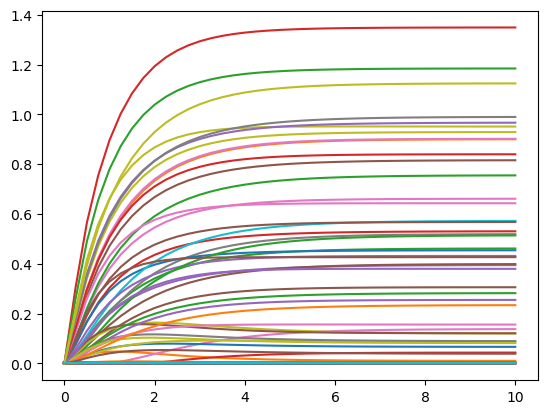

In [7]:
ts = jnp.arange(ts[0], ts[-1] + dt0, dt0)
plt.plot(ts, nn_act(dt0, ts, train_ds['image'][0], evolving_out=True));

In [8]:
from functools import partial
from jax import jit

@partial(jit, static_argnames=['alpha'])
def loss(images, W, lam=0.01, alpha=1.):
    N, in_size = images.shape
    func = MirrorDescent(hidden_size, W, lam=lam, alpha=alpha)
    solver = diffrax.Heun
    nn_act = NeuralActivity(hidden_size, func, solver)
    ts = [0, 10]
    dt0 = 0.25

    res = vmap(lambda x: nn_act(dt0, ts, x))(images)
    if alpha == 1:
        return (jnp.square(images - res.squeeze() @ W).sum()/2 + func.lam * res.sum())/N
    else:
        return (jnp.square(images - res.squeeze() @ W).sum()/2 + func.lam * (res >= func.lam).sum())/N

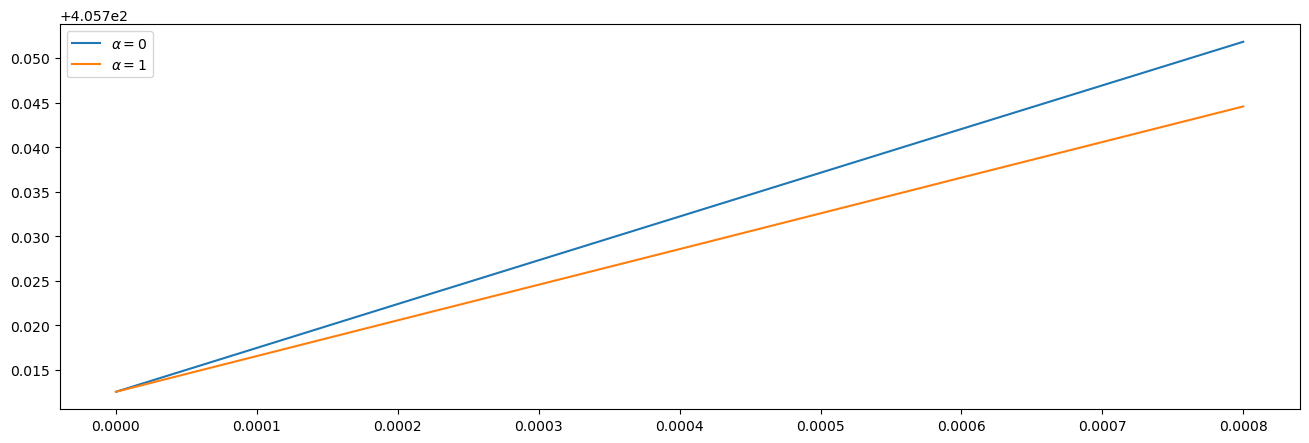

In [9]:
lams = jnp.arange(0, 0.001, 0.0002)
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True, sharey=True)
for i, alpha in enumerate([0, 1]):
    md_losses = vmap(lambda x: loss(train_ds['image'], W, lam=x, alpha=alpha))(lams)
    axes.plot(lams, md_losses, label=r'$\alpha={}$'.format(alpha))
plt.legend();

In [10]:
from numpyro.distributions.util import safe_normalize
from jax.lax import fori_loop, scan
from jax import checkpoint

def training(rng_key, images, epochs=100, lam=0., alpha=0., gamma=1., lr=1e-4):
    hidden_size = 100 
    W = dist.ProjectedNormal(jnp.zeros(in_size)).expand([hidden_size]).sample(random.PRNGKey(0))

    ts = [0, 10]
    dt0 = 0.25

    def inner_scan_fn(carry, a0):
        W = carry
        
        func = MirrorDescent(hidden_size, W, lam=lam, alpha=alpha, gamma=gamma)
        nn_act = NeuralActivity(hidden_size, func, solver)

        a1 = nn_act(dt0, ts, a0)[0]
        _W = W + lr * jnp.expand_dims(a1, -1) * (a0 - a1 @ W)
        return safe_normalize(_W), None

    @checkpoint
    def scan_fn(carry, i):
        rng_key, W = carry
        rng_key, _rng_key = random.split(rng_key)
        W, _ = scan(inner_scan_fn, W, random.shuffle(_rng_key, images))
        ls = loss(images, W, lam=lam, alpha=alpha)
        return (rng_key, W), ls
    
    W, losses = scan(scan_fn, (rng_key, W), jnp.arange(epochs))
    return W, losses

In [13]:
W, losses = training(random.PRNGKey(111), train_ds['image'][1000:], epochs=100)
plt.plot(losses)

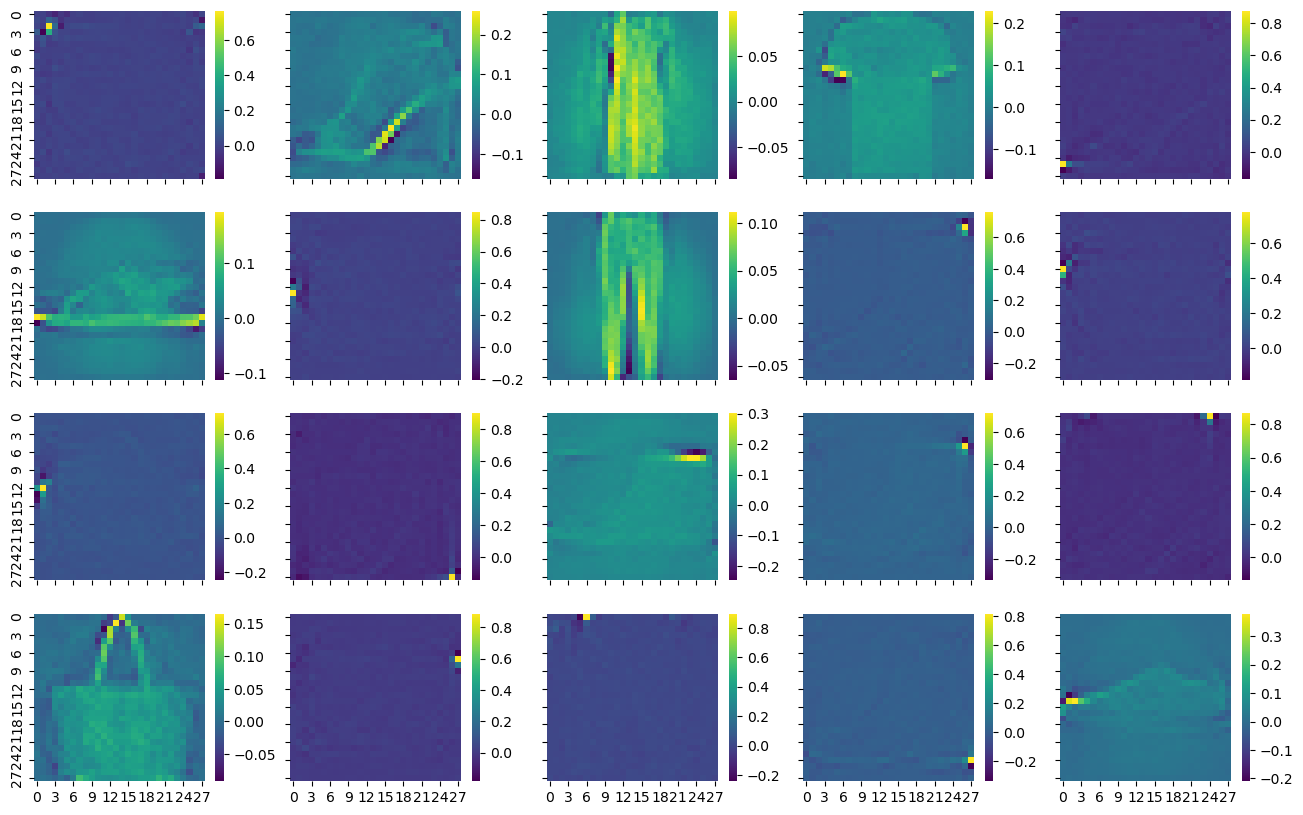

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(16, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(W[i].reshape(28, 28), cmap='viridis', ax=ax)